In [1]:
from examples.tvb_nest.notebooks.cerebellum.scripts import *

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/utils/data_structures_utils.py:718: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (transpose is "horizontal" or "row" and shape[0] > shape[1]) or \
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/utils/data_structures_utils.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
  (transpose is "vertical" or "column" and shape[0] < shape[1]):


2022-05-19 08:24:11,890 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:24:11,890 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:24:11,903 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:24:11,903 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:24:11,905 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:24:11,905 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:24:11,908 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:24:11,908 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:24:11,911 - INFO - tvb_multiscale.tv

<Figure size 432x288 with 0 Axes>

params =
 OrderedDict([('STIMULUS', 5.0), ('I_E', 0.25), ('I_S', -0.25), ('W_IE', 0.25), ('W_RS', -3.0), ('TAU_E', -2.0), ('TAU_I', 11.11111111111111), ('TAU_S', 11.11111111111111), ('TAU_R', 40.0)])


Fitting for G = 2.5!


normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]


/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, device_set=pd.Series(), **kwargs):


Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-19 08:24:14,377 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 09f944e1-de73-4acc-b4f4-a5abbd5cd3ef'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 56a37aaa-23ce-4555-b332-4bda2ad276ca
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... -------

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

2022-05-19 08:24:50,525 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:24:50,525 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-19 08:24:50,526 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:24:50,526 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-19 08:24:50,527 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:24:50,527 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-19 08:24:50,529 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:24:50,529 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-19 08:24:50,530 - INFO - tvb_multiscale.tv

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarnin


normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-19 08:24:55,189 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-19 08:24:55,238 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-19 08:24:55,272 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - C

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...
major_structs_labels:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Specific Thalamus' 'Left Spinal nucleus of the trigeminal'
 'Left Striatum' 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Specific Thalamus' 'Right Spinal nucleus of the trigeminal'
 'Right Striatum']
ROI inds:
 {'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  

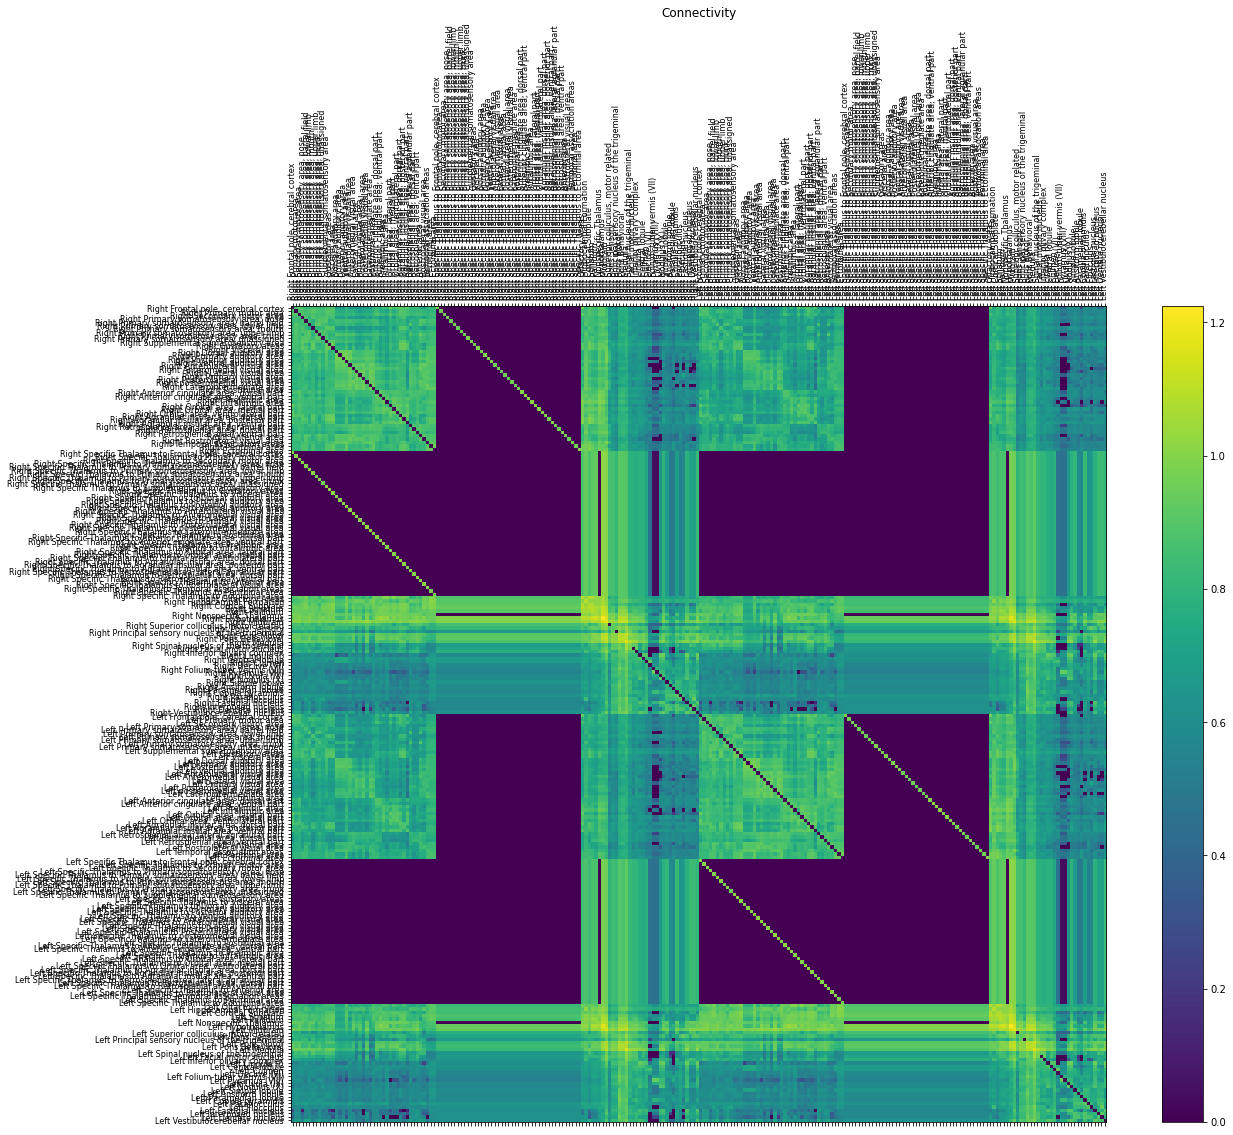

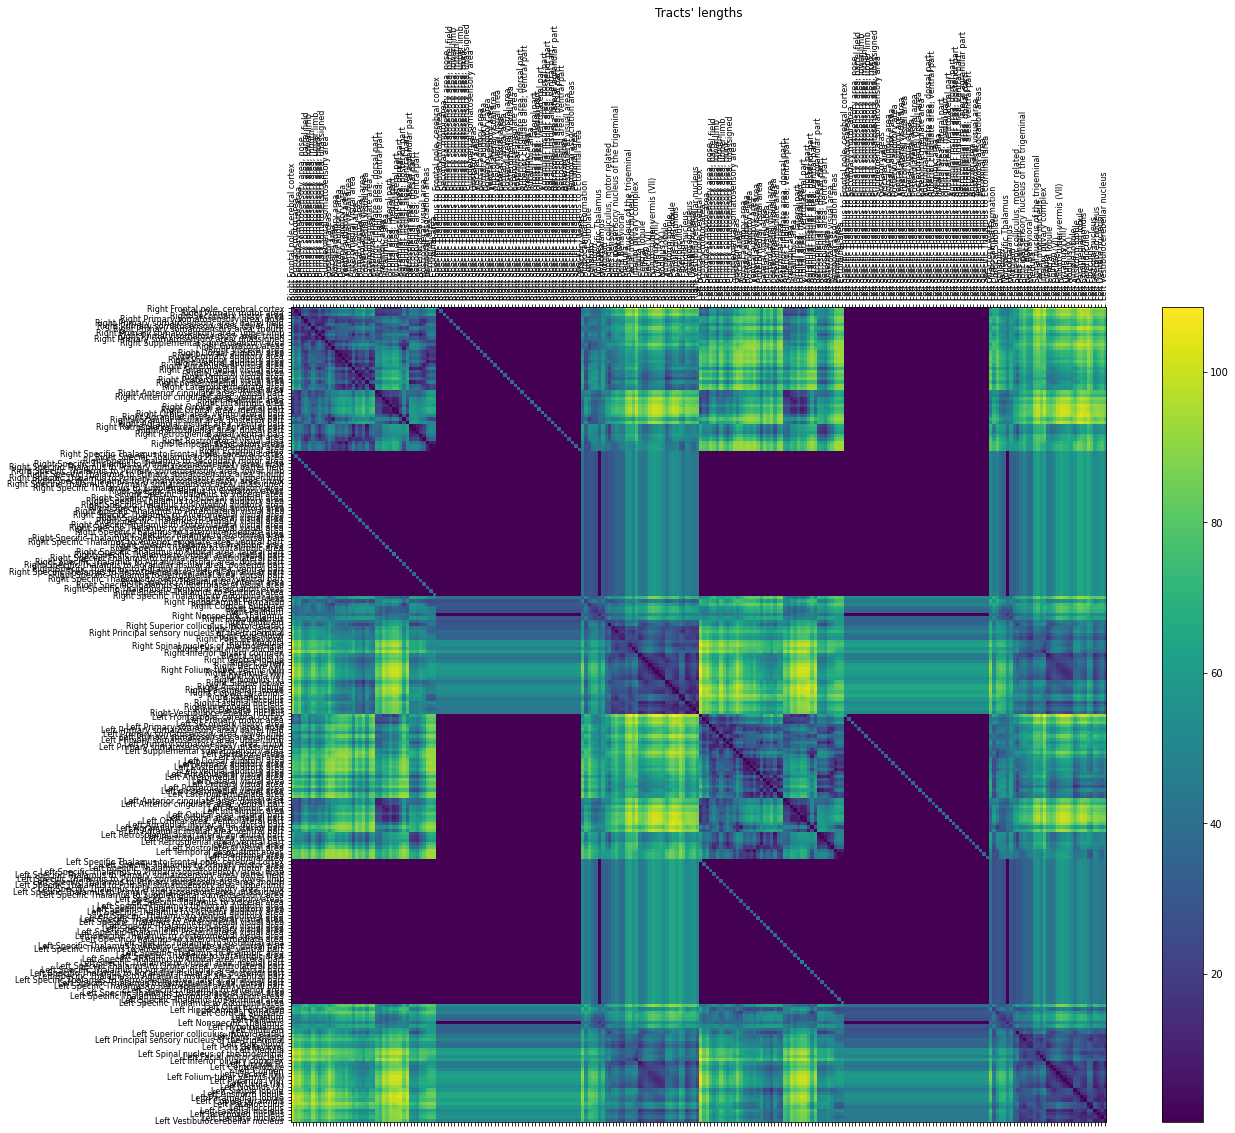

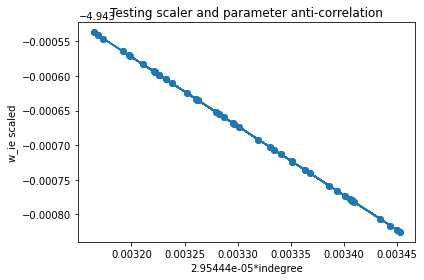

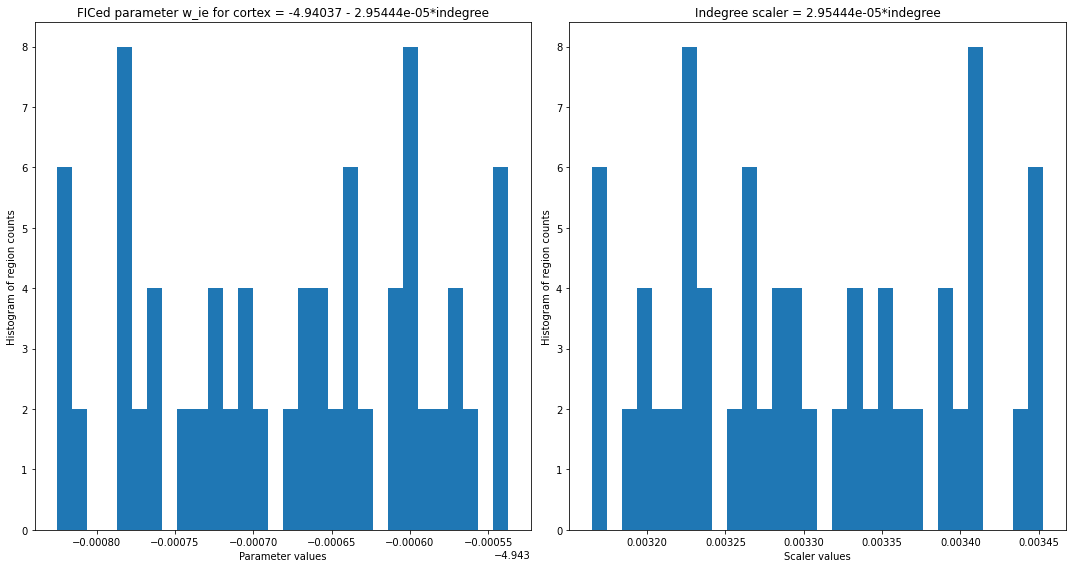

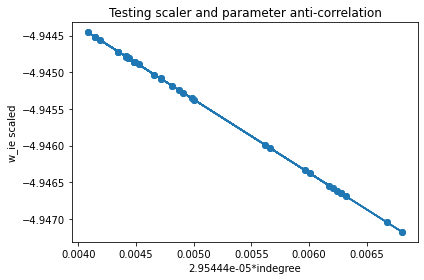

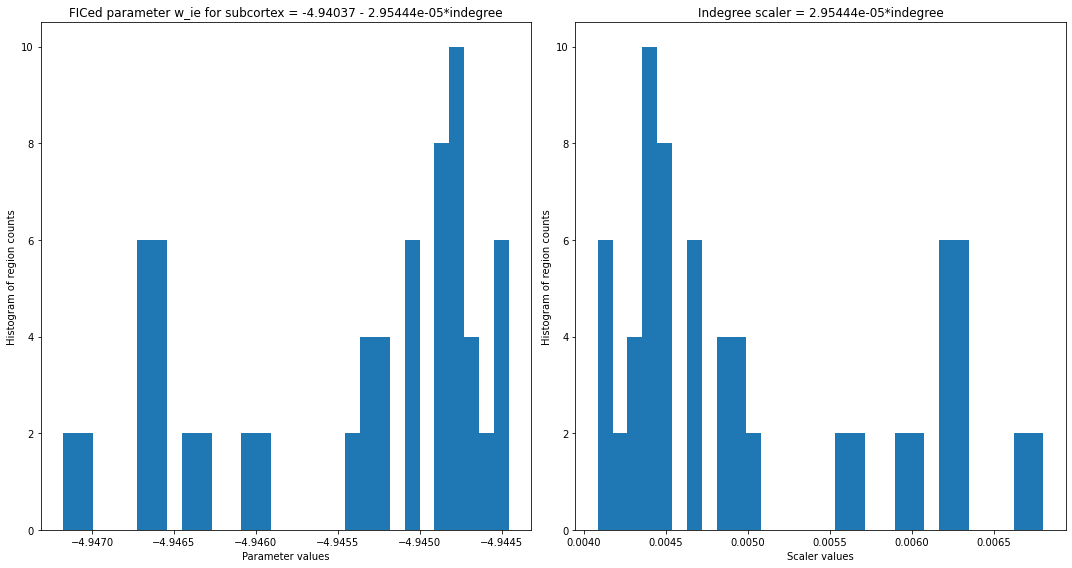

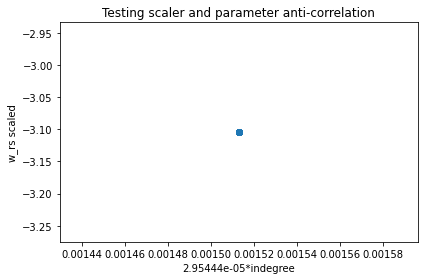

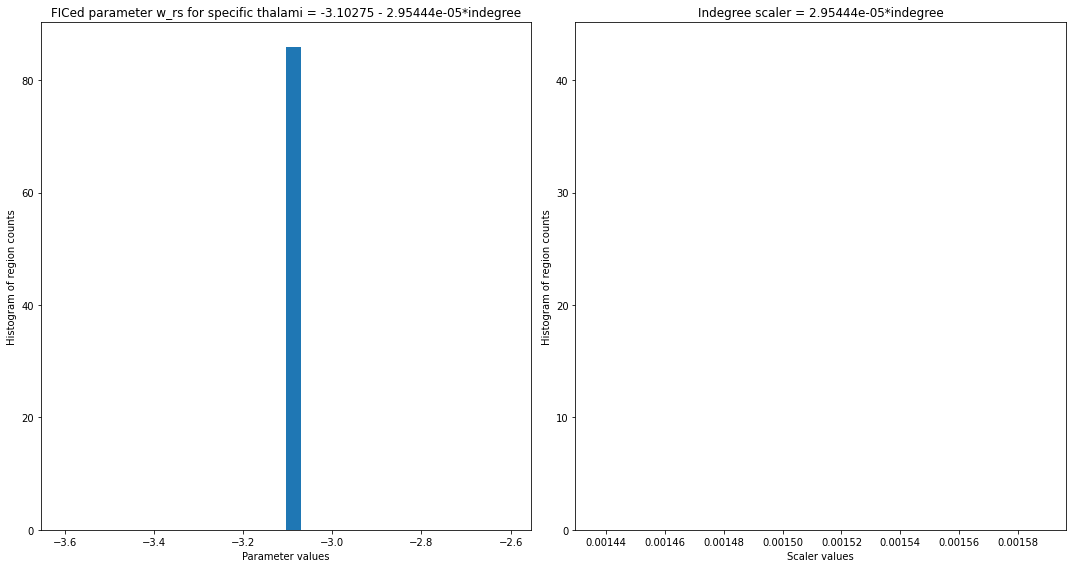

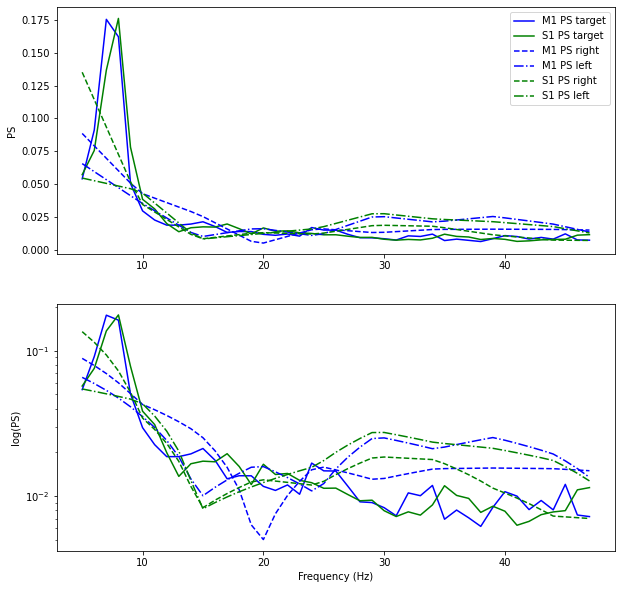

In [2]:
samples_fit_Gs, results, fig = sbi_fit(5, config=None);
# run_workflow(plot_flag=True)

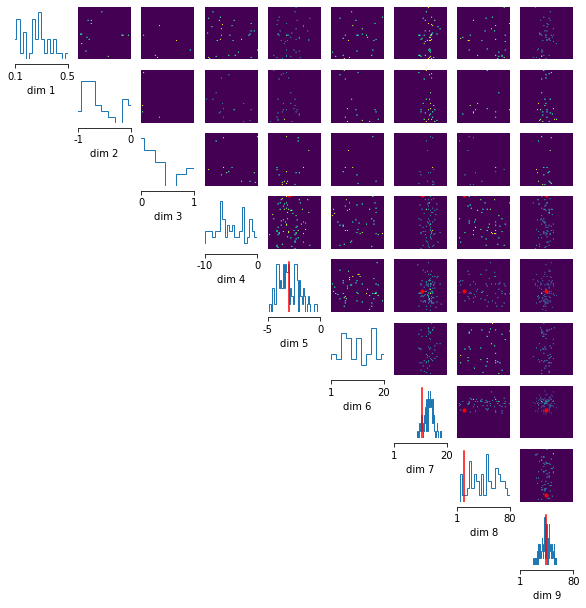

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 1b9d2d4e-4137-4ee3-8c20-fab4744a45a0'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 2b7770d7-33fc-48cd-899a-b7be0eca3397
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 73f3b2f0-43f6-417e-8331-f38520caaba7
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 6efc97bd-f44d-4179-a2f5-0102ddb69fdf
  surface .................. None
  stimu

In [3]:
fig